# L11 - Uczenie reprezentacji

Na dzisiejszych zajęciach dowiemy się o paru metodach nauki reprezentacji (a nie gęstości danych), co może być przydatne do projektu (w szczególności autoenkodery).

Ref:
* (Repr. Learning, review) http://www.cl.uni-heidelberg.de/courses/ws14/deepl/BengioETAL12.pdf
* (Deep Learning book, ch. 15) http://www.deeplearningbook.org/
* (Autoenkodery w Keras) https://blog.keras.io/building-autoencoders-in-keras.html
* (Bardzo polecam, czego uczą się autoenkodery) https://gabgoh.github.io/ThoughtVectors/
* (Isomap) http://wearables.cc.gatech.edu/paper_of_week/isomap.pdf
* (Dobry opis konwolucyjnych sieci) http://cs231n.github.io/convolutional-networks/
* (Slajdy prof. Hintona na temat Isomap oraz tSNE) https://www.cs.toronto.edu/~hinton/csc2535/notes/lec11new.ppt
* (How to use tsne) http://distill.pub/2016/misread-tsne/

In [1]:
import matplotlib.pylab as plt
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
%matplotlib inline

In [2]:
import numpy as np
import sklearn
from sklearn.manifold import Isomap
from sklearn.decomposition import RandomizedPCA

In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

Using Theano backend.


# Zbiory danych

* Swissroll (2 -> 3)

* MNIST (? -> 784), ? pewnie nie dużo większe niż 30

In [4]:
## Swissroll
n_samples = 1500
noise = 0.05
X_swissroll, z_swissroll = make_swiss_roll(n_samples, noise)
X_swissroll[:, 1] *= .5
X_test_swissroll, z_test_swissroll = make_swiss_roll(n_samples/10, noise)
X_test_swissroll[:, 1] *= .5

In [5]:
## MNIST
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
x_mnist_train = x_mnist_train.astype('float32') / 255.
x_mnist_test = x_mnist_test.astype('float32') / 255.
x_mnist_train = x_mnist_train.reshape((len(x_mnist_train), np.prod(x_mnist_train.shape[1:])))
x_mnist_test = x_mnist_test.reshape((len(x_mnist_test), np.prod(x_mnist_test.shape[1:])))

ids_train_small = np.random.choice(len(x_mnist_train), 1500, replace=False)
ids_test_small = np.random.choice(len(x_mnist_test), 1500, replace=False)
x_mnist_train_small = x_mnist_train[ids_train_small]
x_mnist_test_small = x_mnist_test[ids_test_small]
y_mnist_train_small = y_mnist_train[ids_train_small]
y_mnist_test_small = y_mnist_test[ids_test_small]

# Modele

In [20]:
def build_autoencoder(activation='relu', output_activation='sigmoid', hidden_dim=32, input_dim=784):
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(hidden_dim, activation=activation)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation=output_activation)(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded 
    encoded_input = Input(shape=(hidden_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [ ]:
def build_conv_autoencoder(activation='relu', output_activation='sigmoid', hidden_dim=32, input_dim=784):
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(hidden_dim, activation=activation)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation=output_activation)(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded 
    encoded_input = Input(shape=(hidden_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

# Postawienie problemu

## Odwracanie funkcji

Z jednej strony możemy patrzeć na problem uczenia nienadzorowanego jako problemu "odwrócenia" funkcji generującej dane.

Przykładowo, punkt ze zbioru danych swissroll powstaje przez wylosowanie 2 zmiennych $u_1$ oraz $u_2$ a potem ich zanurzeniu w 3 wymiarach. Ten proces staramy się odwrócić i znaleźć (nieliniowy) układ współrzędnych w którym swissroll "jest wypłaszczony".

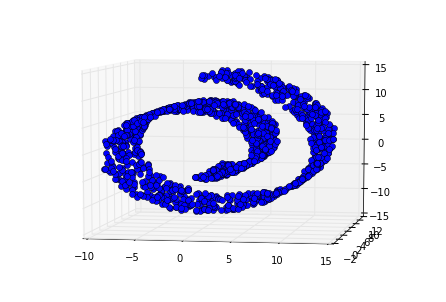

In [16]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.plot3D(X_swissroll[:,0], X_swissroll[:, 1], X_swissroll[:, 2], 'o')

<img width=300 src="https://github.com/gmum/ml2017/raw/master/figures/L11/swissroll.png">

## Maximum likelihood

Z drugiej strony popularnym podejściem jest stawianie problemu uczenia nienadzorowanego jako znajdowania rozwiązania 

$$ \theta^{*} = argmax_{\theta} \mathbb{E}[p_\theta(x)] $$

Co istotne, jeśli naszym celem jest nauka cech (a nie aproksymacja gęstości), to nie ma zadnych gwarancji że podejścia typu "maximum likelihood" nauczą się ciekawych cech, patrz np. http://www.inference.vc/maximum-likelihood-for-representation-learning-2/.

# PCA / liniowy autoenkoder

Najprostsza sieć neuronowa do nauki cech jednocześnie implementuje PCA ("In the auto-associative case ... and therefore the unique locally and globally optimal map W is the orthogonal projection onto the space spanned by the first pp eigenvectors of ΣXX").

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/autoencoder_schema.jpg" width=500>

Dla liniowej funkcji enkoder metoda znajduje to samo co PCA:

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/pca.png" width=500>

## Swissroll

Train on 1500 samples, validate on 150 samples
Epoch 1/50
1500/1500 [==============================] - 0s - loss: -30.4248 - val_loss: -30.6248
Epoch 2/50
1500/1500 [==============================] - 0s - loss: -30.5500 - val_loss: -30.6684
Epoch 3/50
1500/1500 [==============================] - 0s - loss: -30.7275 - val_loss: -30.7133
Epoch 4/50
1500/1500 [==============================] - 0s - loss: -30.8874 - val_loss: -30.7422
Epoch 5/50
1500/1500 [==============================] - 0s - loss: -30.9894 - val_loss: -30.7742
Epoch 6/50
1500/1500 [==============================] - 0s - loss: -31.1555 - val_loss: -30.8249
Epoch 7/50
1500/1500 [==============================] - 0s - loss: -31.2367 - val_loss: -30.8509
Epoch 8/50
1500/1500 [==============================] - 0s - loss: -31.2682 - val_loss: -31.0007
Epoch 9/50
1500/1500 [==============================] - 0s - loss: -31.3559 - val_loss: -31.0212
Epoch 10/50
1500/1500 [==============================] - 0s - loss: -31.4538 - v

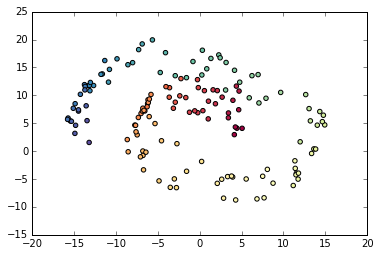

In [12]:
autoencoder, encoder, decoder = build_autoencoder(activation='linear', output_activation='linear',
                                                 hidden_dim=2, input_dim=3)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(X_swissroll, X_swissroll,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(X_test_swissroll, X_test_swissroll))

# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
X_test_swissroll_proj = encoder.predict(X_test_swissroll)


plt.scatter(X_test_swissroll_proj[:, 0], X_test_swissroll_proj[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## MNIST

In [ ]:
## Najpierw narysujmy przestrzeń 2d

[]

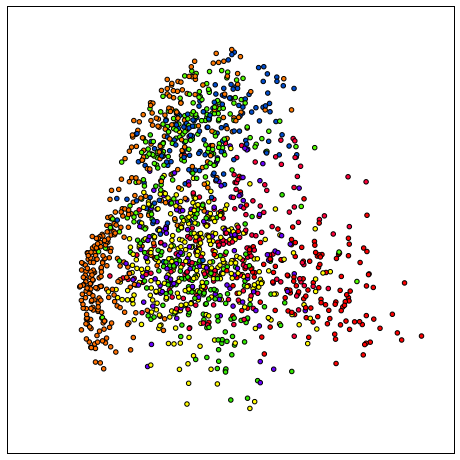

In [87]:
pca = RandomizedPCA(n_components=2, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()
x_mnist_train_transformed_small = pca.fit_transform(x_mnist_train_small.reshape(x_mnist_train_small.shape[0], -1))
plot.scatter(x_mnist_train_transformed_small[:, 0], x_mnist_train_transformed_small[:, 1], c=y_mnist_train_small)
plot.set_xticks(())
plot.set_yticks(())

In [ ]:
## Teraz rozważmy hidden dim > 2

In [23]:
autoencoder, encoder, decoder = build_autoencoder(activation='linear', output_activation='sigmoid',
                                                 hidden_dim=32, input_dim=784)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [26]:
autoencoder.fit(x_mnist_train, x_mnist_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_mnist_test, x_mnist_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.3575 - val_loss: 0.2705
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.2612 - val_loss: 0.2483
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.2378 - val_loss: 0.2255
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.2184 - val_loss: 0.2093
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.2048 - val_loss: 0.1979
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.1949 - val_loss: 0.1891
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1868 - val_loss: 0.1817
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 0.1797 - val_loss: 0.1750
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.1734 - val_loss: 0.1691
Epoch 10/50
60000/60000 [==============================] - 3s - loss: 0.1678 - val_loss: 0.1639

In [29]:
encoded_imgs = encoder.predict(x_mnist_test)
decoded_imgs = decoder.predict(encoded_imgs)

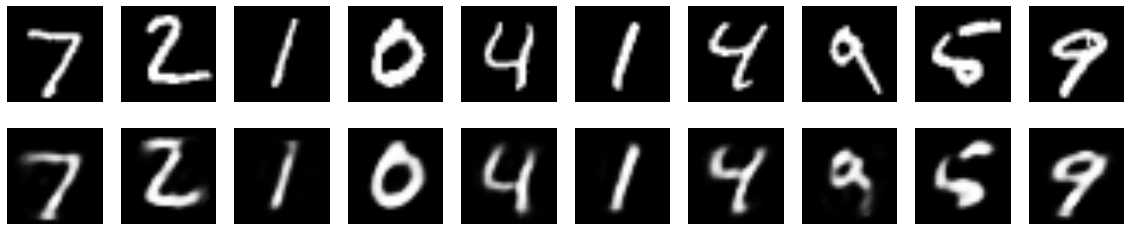

In [31]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Samplowanie

Poza uczeniem się cech, wiele modeli pozwala na efektywne "wymyślanie" (generowanie) przykładów. W niektórych modelach jest to trudne, w innych proste. W przypadku typowych autoenkoderów możliwa jest interpolacja między przykładami.

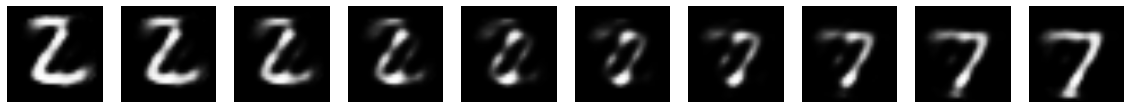

In [39]:
# Policzmy interpolacje miedzy 7 a 2 ze zbioru testowego
interpolated = []
n = 10
plt.figure(figsize=(20, 4))
for i, lerp in enumerate(np.linspace(0, 1, n)):
    interpolated.append(decoder.predict(lerp*encoded_imgs[0:1] + (1-lerp)*encoded_imgs[1:2]))
    
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(interpolated[-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Problemy PCA / liniowego autoenkodera

* Brak modelu prawdopodobieństwa (0 poza nieskończonie małym podzbiorem) - Probabilistic PCA (PPCA), patrz np. http://edwardlib.org/tutorials/probabilistic-pca oraz variational/denoising autoenckoder
* Ciężko generować z modeli (rozwiązywane przez VAE/PPCA)
* Zakłada globalną strukture euklidesową - MDS generalizuje na dowolną metryke
* Zakłada globalną strukturę liniową - Isomap/LLE/kernelPCA/nieliniowe autoenkodery wszystkie rozwiązać ten problem

# Isomap

Isomap jest w pewnym sensie rozszerzeniem PCA do izometrycznych odzworowań (solver w scikit-learn używa kernel PCA wewnątrz). Dalsze modyfikacje rozszerzają do odwzorowań konforemnych (zachowujących kąty). Przez "rozszerzenie" rozumiemy tutaj, że Isomap rozwiązuje problem szukania odwzorowania odwrotnego przy odpowiednio dużej ilości punktów (podczas gdy PCA nigdy nie rozwiąże swissroll, nawet przy nieskończonej próbce danych).

* Isomap w tradycyjnym sformułowaniu nie pozwala na predykcję na nowych punkach (czyli np. samplowanie).

* Isomap ma złożoność O(n^3) przez co niestety jest bardziej ciekawostką, za to całkiem podobne algorytmy, np. t-SNE są dużo szybsze.

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/isomap_distance.png" width=800>

"PCA
finds a low-dimensional embedding of the
data points that best preserves their variance
as measured in the high-dimensional input
space. Classical MDS finds an embedding
that preserves the interpoint distances, equivalent
to PCA when those distances are Euclidean.
However, many data sets contain
essential nonlinear structures that are invisible
to PCA and MDS (4, 5, 11, 14). For
example, both methods fail to detect the true
degrees of freedom of the face data set (Fig.
1A), or even its intrinsic three-dimensionality
(Fig. 2A)."

"Just as PCA and MDS are guaranteed,
given sufficient data, to recover the true
structure of linear manifolds, Isomap is guaranteed
asymptotically to recover the true dimensionality
and geometric structure of a
strictly larger class of nonlinear manifolds"

(Cytaty z http://wearables.cc.gatech.edu/paper_of_week/isomap.pdf)


## Swissroll

Isomap, odwrotnie od PCA/liniowego autoenkodera rozwiązuje całkiem nieźle swissroll

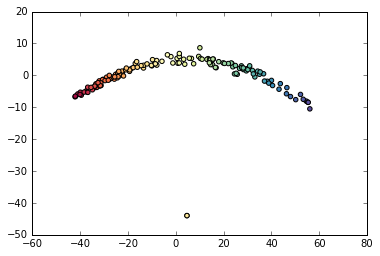

In [89]:
isomap = Isomap().fit(X_swissroll)
X_test_swissroll_proj = isomap.transform(X_test_swissroll)
# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
plt.scatter(X_test_swissroll_proj[:, 0], X_test_swissroll_proj[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## MNIST

[]

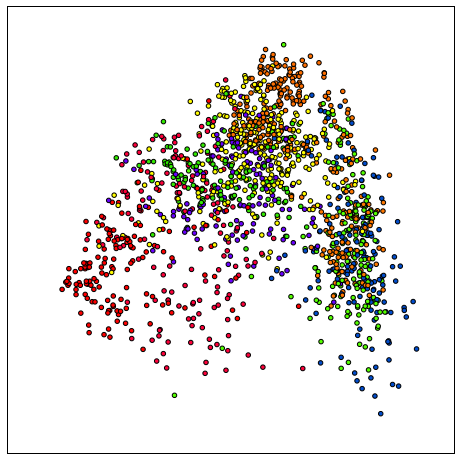

In [88]:
## Isomap na MNIST wizualnie wydaje sie podobny, ale dalsze eksperymenty (samplowanie) pokazuje że jest zwykle lepszy

isomap = Isomap()
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()
x_mnist_train_transformed_small = isomap.fit_transform(x_mnist_train_small.reshape(x_mnist_train_small.shape[0], -1))
plot.scatter(x_mnist_train_transformed_small[:, 0], x_mnist_train_transformed_small[:, 1], c=y_mnist_train_small)
plot.set_xticks(())
plot.set_yticks(())

## Samplowanie

Orginalny isomap nie pozwala, ale są rozszerzenia. Jak widać (z pracy http://web.mit.edu/cocosci/Papers/sci_reprint.pdf) samplowanie  jest bardziej naturalne (porównaj z wykresem z sekcji o PCA):

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/sampling_isomap.png" width=500>

# t-SNE

t-SNE służy do wizualizacji, nie nauki cech! Jest zamieszczony ze względu na ogromną popularność.

Ref: http://distill.pub/2016/misread-tsne/

Różnice z isomap: 
* crowding problem (high dim -> 2 powoduje nowe problemy)
* O(n^2), a nawet O(nlgn) (w porównaniu do złożonosci sześciennej podstawowej wersji Isomap)

Parametry (ważne):
* Learning rate
* Perplexity

"A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities."

TODO: Przekrój

## Swissroll

Nie powinno zadziałać, bo brak charakterystyki zanurzenia wielowymiarowego manifoldu w małowymiarowy.

In [7]:
from sklearn.manifold import TSNE

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.380996
[t-SNE] Iteration 25: error = 4.5521698, gradient norm = 0.0000187
[t-SNE] Iteration 25: gradient norm 0.000019. Finished.
[t-SNE] Iteration 50: error = 4.5638614, gradient norm = 0.0000188
[t-SNE] Iteration 50: gradient norm 0.000019. Finished.
[t-SNE] Error after 50 iterations with early exaggeration: 4.563861
[t-SNE] Iteration 75: error = 4.5351672, gradient norm = 0.0000187
[t-SNE] Iteration 75: gradient norm 0.000019. Finished.
[t-SNE] Error after 75 iterations: 4.535167


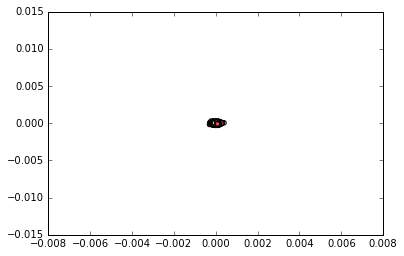

In [67]:
X_swissroll_proj = TSNE(verbose=10, perplexity=3, learning_rate=0.001).fit_transform(X_swissroll)
# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
plt.scatter(X_swissroll_proj[:, 0], X_swissroll_proj[:, 1], c=z_swissroll, cmap=plt.cm.Spectral)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.380996
[t-SNE] Iteration 25: error = 4.6817465, gradient norm = 1.2916366
[t-SNE] Iteration 50: error = 4.6761780, gradient norm = 1.3003041
[t-SNE] Iteration 75: error = 4.6841683, gradient norm = 1.3204350
[t-SNE] Iteration 100: error = 4.6750450, gradient norm = 1.3441275
[t-SNE] Error after 100 iterations with early exaggeration: 4.675045
[t-SNE] Iteration 125: error = 4.6626992, gradient norm = 1.3487391
[t-SNE] Iteration 150: error = 4.6746526, gradient norm = 1.3362366
[t-SNE] Iteration 175: error = 4.6762424, gradient norm = 1.3432977
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 4.676242


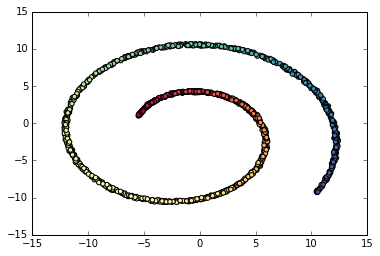

In [68]:
X_swissroll_proj = TSNE(verbose=10, perplexity=3, learning_rate=0.01, init="pca").fit_transform(X_swissroll)
# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
plt.scatter(X_swissroll_proj[:, 0], X_swissroll_proj[:, 1], c=z_swissroll, cmap=plt.cm.Spectral)

## MNIST

t-SNE ma też problemy z "surowymi" danymi (nie jest to metoda nauki reprezentacji). Jak zobaczymy w ćwiczeniu, t-SNE za to działa świetnie do wizualizacji już nauczonych cech.

In [9]:
# Dla t-sne srednia nie jest istotna, ale skala tak
x_mnist_train_small_standardized = x_mnist_train_small/ (1e-10 + np.std(x_mnist_train_small, axis=0, keepdims=True))

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 6.742655
[t-SNE] Iteration 25: error = 2.5874984, gradient norm = 1.2348435
[t-SNE] Iteration 50: error = 2.6005511, gradient norm = 1.3241662
[t-SNE] Iteration 75: error = 2.6313767, gradient norm = 1.5975906
[t-SNE] Iteration 100: error = 2.6545684, gradient norm = 1.8466358
[t-SNE] Error after 100 iterations with early exaggeration: 2.654568
[t-SNE] Iteration 125: error = 2.6715615, gradient norm = 2.2506807
[t-SNE] Iteration 150: error = 2.6853499, gradient norm = 2.7249334
[t-SNE] Iteration 175: error = 2.6930966, gradient norm = 3.1261132
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 2.693097


[]

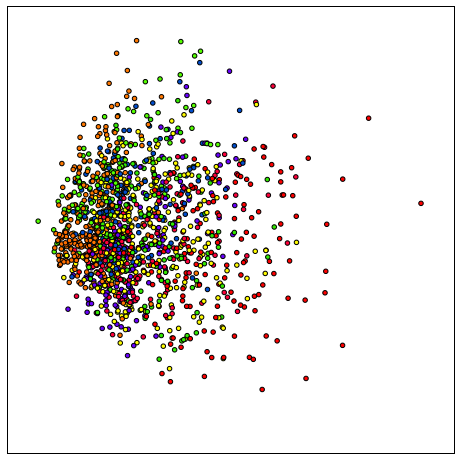

In [45]:
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()
x_mnist_train_small_standardized_proj = TSNE(verbose=2, learning_rate=1, init="pca").\
    fit_transform(x_mnist_train_small_standardized.reshape(x_mnist_train_small_standardized.shape[0], -1))
plot.scatter(x_mnist_train_small_standardized_proj[:, 0], x_mnist_train_small_standardized_proj[:, 1], c=y_mnist_train_small)
plot.set_xticks(())
plot.set_yticks(())

# Nieliniowy autoenkoder

Ref: http://gabgoh.github.io/ThoughtVectors/, https://blog.keras.io/building-autoencoders-in-keras.html

## Swissroll

Train on 1500 samples, validate on 150 samples
Epoch 1/50
1500/1500 [==============================] - 0s - loss: 41.7805 - val_loss: 43.3966
Epoch 2/50
1500/1500 [==============================] - 0s - loss: 40.4271 - val_loss: 41.8426
Epoch 3/50
1500/1500 [==============================] - 0s - loss: 39.2515 - val_loss: 40.8967
Epoch 4/50
1500/1500 [==============================] - 0s - loss: 38.2918 - val_loss: 39.7453
Epoch 5/50
1500/1500 [==============================] - 0s - loss: 37.0918 - val_loss: 38.0274
Epoch 6/50
1500/1500 [==============================] - 0s - loss: 35.9114 - val_loss: 37.1365
Epoch 7/50
1500/1500 [==============================] - 0s - loss: 34.6508 - val_loss: 36.9247
Epoch 8/50
1500/1500 [==============================] - 0s - loss: 34.0741 - val_loss: 36.4099
Epoch 9/50
1500/1500 [==============================] - 0s - loss: 33.3434 - val_loss: 35.6417
Epoch 10/50
1500/1500 [==============================] - 0s - loss: 32.5569 - val_loss: 35.5195
Ep

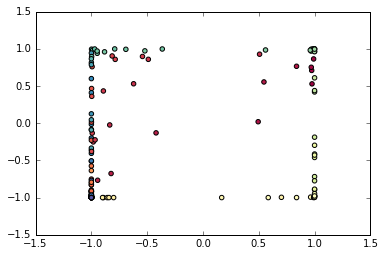

In [51]:
autoencoder, encoder, decoder = build_autoencoder(activation='tanh', output_activation='linear',
                                                 hidden_dim=5, input_dim=3)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(X_swissroll, X_swissroll,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(X_test_swissroll, X_test_swissroll))

# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
X_test_swissroll_proj = encoder.predict(X_test_swissroll)


plt.scatter(X_test_swissroll_proj[:, 0], X_test_swissroll_proj[:, 1], c=z_test_swissroll, 
            cmap=plt.cm.Spectral)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.783501
[t-SNE] Iteration 25: error = 1.5137213, gradient norm = 1.9953781
[t-SNE] Iteration 50: error = 2.8216817, gradient norm = 2.9605958
[t-SNE] Iteration 75: error = 4.8581519, gradient norm = 13.3636084
[t-SNE] Iteration 100: error = 5.2855406, gradient norm = 54.0699081
[t-SNE] Error after 100 iterations with early exaggeration: 5.285541
[t-SNE] Iteration 125: error = 5.3621941, gradient norm = 327.7604370
[t-SNE] Iteration 150: error = 5.3651152, gradient norm = 1037.6490479
[t-SNE] Iteration 175: error = 5.3655076, gradient norm = 3644.3525391
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 5.365508


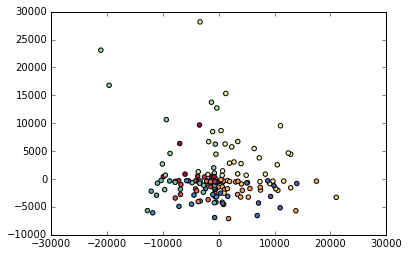

In [52]:
X_test_swissroll_proj_tsne = TSNE(verbose=10, learning_rate=1, init="pca", n_iter=10000).fit_transform(X_test_swissroll_proj)
# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
plt.scatter(X_test_swissroll_proj_tsne[:, 0], X_test_swissroll_proj_tsne[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## Interrim - konwolucje

Ref: http://cs231n.github.io/convolutional-networks/

<img src="figures/L11/conv1.jpeg" width=500>

(Wersja animowana dostępna na http://cs231n.github.io/convolutional-networks/)

<img src="figures/L11/conv3.png" width=500>

## MNIST

(Rozważamy tutaj konwolucje, patrz wykład)

## Swissroll

## Zadanie 1 - nieliniowy autoenkoder na CIFAR10/MNIST [5 pkt]

1. Sprawdź jak wygląda interpolacja dla CIFAR10 (patrz projekt.ipynb) i MNIST dla nieliniowego autoenkodera. [2 pkt]
2. Narysuj wykres t-SNE przestrzeni latent (encoder(CIFAR10_test)) z zaznaczonym interpolowanymi punktami za czerwono. [2 pkt]
3. Czy można policzyć likelihood danych wg. rozważanego nieliniowego autoenkodera? [1pkt]

# O czym nie wspominamy

* Klastrowanie (w szczególności spectral clustering)
* GAN 
* kernel PCA / probabilistic PCA

# Algebra na reprezentacji

In [ ]:
# TODO: Rozwiązać similarity za pomocą word embeddingów

# TODO: Wykres analogy word embeddingów